## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/evolution-strategies-from-scratch-in-python/)) <font size='3ptx'>**Evolution strategies is a stochastic global optimization algorithm.**</font>

It is an [**evolutionary algorithm**](https://en.wikipedia.org/wiki/Evolutionary_algorithm) related to others, such as the genetic algorithm, although it is designed specifically for continuous function optimization. **In this tutorial, you will discover how to implement the evolution strategies optimization algorithm.**

After completing this tutorial, you will know:
* Evolution Strategies is a stochastic global optimization algorithm inspired by the biological theory of evolution by natural selection.
* There is a standard terminology for Evolution Strategies and two common versions of the algorithm referred to as (mu, lambda)-ES and (mu + lambda)-ES.
* How to implement and apply the Evolution Strategies algorithm to continuous objective functions.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into three parts; they are:
* <font size='3ptx'>[**Evolution Strategies**](#sect1)</font>
* <font size='3ptx'>[**Develop a (mu, lambda)-ES**](#sect2)</font>
* <font size='3ptx'>[**Develop a (mu + lambda)-ES**](#sect3)</font>

<a id='sect1'></a>
## <font color='darkblue'>Evolution Strategies</font>
**[Evolution Strategies](https://en.wikipedia.org/wiki/Evolution_strategy), sometimes referred to as Evolution Strategy (singular) or ES, is a stochastic global optimization algorithm.**

The technique was developed in the 1960s to be implemented manually by engineers for minimal drag designs in a wind tunnel.
> The family of algorithms known as Evolution Strategies (ES) were developed by Ingo Rechenberg and Hans-Paul Schwefel at the Technical University of Berlin in the mid 1960s.<br/><br/>
> [**— Page 31, Essentials of Metaheuristics, 2011.**](https://amzn.to/37mn7PN)
<br/>

Evolution Strategies is a type of evolutionary algorithm and is inspired by the biological theory of evolution by means of natural selection. Unlike other evolutionary algorithms, it does not use any form of crossover; instead, modification of candidate solutions is limited to mutation operators. In this way, **Evolution Strategies may be thought of as a type of parallel stochastic hill climbing.**

The algorithm involves a population of candidate solutions that initially are randomly generated. Each iteration of the algorithm involves first evaluating the population of solutions, then deleting all but a subset of the best solutions, referred to as truncation selection. The remaining solutions (<font color='brown'>the parents</font>) each are used as the basis for generating a number of new candidate solutions (<font color='brown'>mutation</font>) that replace or compete with the parents for a position in the population for consideration in the next iteration of the algorithm (<font color='brown'>generation</font>).

There are a number of variations of this procedure and a standard terminology to summarize the algorithm. **The size of the population is referred to as `lambda` and the number of parents selected each iteration is referred to as `mu`.**

The number of children created from each parent is calculated as ($lambda / mu$) and parameters should be chosen so that the division has no remainder.
* **mu**: The number of parents selected each iteration.
* **lambda**: Size of the population.
* **lambda / mu**: Number of children generated from each selected parent.

**A bracket notation is used to describe the algorithm configuration, e.g. (mu, lambda)-ES.** For example, if `mu=5` and `lambda=20`, then it would be summarized as `(5, 20)-ES`. A comma (,) separating the mu and lambda parameters indicates that the children replace the parents directly each iteration of the algorithm.
* **(mu, lambda)-ES:** A version of evolution strategies where children replace parents.

A plus (+) separation of the mu and lambda parameters indicates that the children and the parents together will define the population for the next iteration.
* **(mu + lambda)-ES:** A version of evolution strategies where children and parents are added to the population.

A stochastic hill climbing algorithm can be implemented as an Evolution Strategy and would have the notation `(1 + 1)-ES`. This is the simile or canonical ES algorithm and there are many extensions and variants described in the literature.

<a id='sect2'></a>
## <font color='darkblue'>Develop a (mu, lambda)-ES</font>
**In this section, we will develop a `(mu, lambda)-ES`, that is, a version of the algorithm where children replace parents.**

First, let’s define a challenging optimization problem as the basis for implementing the algorithm. The [**Ackley function**](https://en.wikipedia.org/wiki/Ackley_function) is an example of a multimodal objective function that has a single global optima and multiple local optima in which a local search might get stuck.

As such, a global optimization technique is required. It is a two-dimensional objective function that has a global optima at `[0,0]`, which evaluates to 0.0. **The example below implements the [Ackley](https://en.wikipedia.org/wiki/Ackley_function) and creates a three-dimensional surface plot showing the global optima and multiple local optima.**

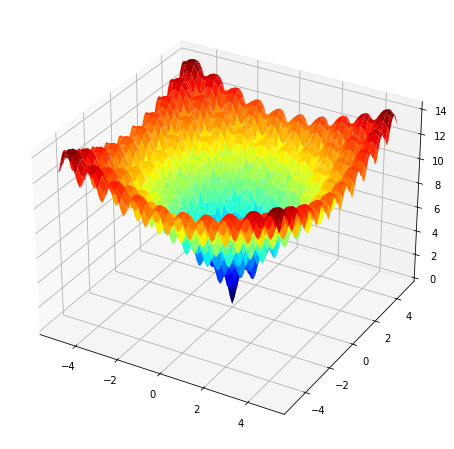

In [24]:
# ackley multimodal function
import numpy as np
import pandas as pd
from numpy import arange
from numpy import exp
from numpy import sqrt
from numpy import argsort
from numpy import cos
from numpy import e
from numpy import pi
from numpy import meshgrid
from numpy.random import randn
from random import seed
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
 
# objective function
def objective(x, y):
    return -20.0 * exp(-0.2 * sqrt(0.5 * (x**2 + y**2))) - exp(0.5 * (cos(2 * pi * x) + cos(2 * pi * y))) + e + 20
 
def draw_objective(objective=objective, r_min=-5.0, r_max=5.0):
    '''
    :r_min, r_max:
        Define range for input  
    '''
    # sample input range uniformly at 0.1 increments
    xaxis = arange(r_min, r_max, 0.1)
    yaxis = arange(r_min, r_max, 0.1)
    
    # create a mesh from the axis
    x, y = meshgrid(xaxis, yaxis)
    
    # compute targets
    results = objective(x, y)
    
    # create a surface plot with the jet color scheme
    figure = plt.figure(figsize=(10, 8))
    axis = figure.gca(projection='3d')
    axis.plot_surface(x, y, results, cmap='jet')
    
    # show the plot
    plt.show()
    
draw_objective()

We will be generating random candidate solutions as well as modified versions of existing candidate solutions. It is important that all candidate solutions are within the bounds of the search problem.

To achieve this, we will develop a function to check whether a candidate solution is within the bounds of the search and then discard it and generate another solution if it is not. The <font color='blue'>in_bounds()</font> function below will take a candidate solution (<font color='brown'>point</font>) and the definition of the bounds of the search space (<font color='brown'>bounds</font>) and return True if the solution is within the bounds of the search or False otherwise.

In [9]:
# check if a point is within the bounds of the search
def in_bounds(point, bounds):
    # enumerate all dimensions of the point
    for d in range(len(bounds)):
        # check if out of bounds for this dimension
        if point[d] < bounds[d, 0] or point[d] > bounds[d, 1]:
            return False
        
    return True

We can then use this function when generating the initial population of “lam” (<font color='brown'>e.g. lambda</font>) random candidate solutions. For example:
```python
# initial population
population = list()
for _ in range(lam):
    candidate = None
    while candidate is None or not in_bounds(candidate, bounds):
        candidate = bounds[:, 0] + rand(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
        population.append(candidate)
```

Next, we can iterate over a fixed number of iterations of the algorithm. Each iteration first involves evaluating each candidate solution in the population. We will calculate the scores and store them in a separate parallel list.
```python
# evaluate fitness for the population
scores = [objective(c) for c in population]
```

Next, we need to select the “`mu`” parents with the best scores, lowest scores in this case, as we are minimizing the <font color='blue'>objective</font> function.

We will do this in two steps. First, we will rank the candidate solutions based on their scores in ascending order so that the solution with the lowest score has a rank of 0, the next has a rank 1, and so on. We can use a double call of the [argsort](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html) function to achieve this.

We will then use the ranks and select those parents that have a rank below the value “`mu.`” This means if `mu` is set to 5 to select 5 parents, only those parents with a rank between 0 and 4 will be selected.
```python
# rank scores in ascending order
ranks = argsort(argsort(scores))
# select the indexes for the top mu ranked solutions
selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
```

We can then create children for each selected parent. First, we must calculate the total number of children to create per parent.
```python
# calculate the number of children per parent
n_children = int(lam / mu)
```

We can then iterate over each parent and create modified versions of each.

We will create children using a similar technique used in stochastic hill climbing. Specifically, each variable will be sampled using a Gaussian distribution with the current value as the mean and the standard deviation provided as a “`step_size`” hyperparameter.
```python
# create children for parent
for _ in range(n_children):
    child = None
    while child is None or not in_bounds(child, bounds):
        child = population[i] + randn(len(bounds)) * step_size
```

We can also check if each selected parent is better than the best solution seen so far so that we can return the best solution at the end of the search.
```python
# check if this parent is the best solution ever seen
if scores[i] < best_eval:
    best, best_eval = population[i], scores[i]
    print('%d, Best: f(%s) = %.5f' % (epoch, best, best_eval))
```

The created children can be added to a list and we can replace the population with the list of children at the end of the algorithm iteration.
```python
# replace population with children
population = children
```

We can tie all of this together into a function named <font color='blue'>es_comma()</font> that performs the comma version of the Evolution Strategy algorithm.

The function takes the name of the objective function, the bounds of the search space, the number of iterations, the step size, and the `mu` and `lambda` hyperparameters and returns the best solution found during the search and its evaluation.

In [22]:
def es_comma(objective, bounds, n_iter, step_size, mu, lam):
    '''
    objective: function
        objective function
        
    bounds:
        boundary of point
    
    n_iter: int
        iteration round
        
    step_size: int
        step size
        
    mu: int
        The number for the selection of parent
        
    lam: int
        The number of population
    '''
    best, best_eval = None, 1e+10
    
    # calculate the number of children per parent
    n_children = int(lam / mu)
    
    # initial population
    population = list()
    for _ in range(lam):
        candidate = None
        while candidate is None or not in_bounds(candidate, bounds):
            candidate = bounds[:, 0] + randn(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
            
        population.append(candidate)
        
    # perform the search
    for epoch in range(n_iter):    
        # evaluate fitness for the population
        scores = [objective(*c) for c in population]
 
        # rank scores in ascending order
        ranks = argsort(argsort(scores))
    
        # select the indexes for the top mu ranked solutions
        selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
 
        # create children from parents
        children = list()
 
        for i in selected:
            # check if this parent is the best solution ever seen
            if scores[i] < best_eval:
                best, best_eval = population[i], scores[i]
                print('%d, Best: f(%s) = %.5f' % (epoch, best, best_eval))
                
            # create children for parent
            for _ in range(n_children):
                child = None
                while child is None or not in_bounds(child, bounds):
                    child = population[i] + randn(len(bounds)) * step_size
                children.append(child)
                
        # replace population with children            
        population = children
            
    return [best, best_eval]

Next, we can apply this algorithm to our [**Ackley objective function**](https://en.wikipedia.org/wiki/Ackley_function).

We will run the algorithm for 5,000 iterations and use a `step_size` of 0.15 in the search space. We will use a population size (`lambda`) of 100 and select 20 parents (`mu`). These hyperparameters were chosen after a little trial and error.

At the end of the search, we will report the best candidate solution found during the search.

In [25]:
# seed the pseudorandom number generator
seed(1)

# define range for input
bounds = np.array([[-5.0, 5.0], [-5.0, 5.0]])

# define the total iterations
n_iter = 5000

# define the maximum step size
step_size = 0.15

# number of parents selected
mu = 20

# the number of children generated by parents
lam = 100

# perform the evolution strategy (mu, lambda) search
best, score = es_comma(objective, bounds, n_iter, step_size, mu, lam)
print('Done!')
print('f(%s) = %f' % (best, score))

0, Best: f([ 0.984699   -2.11177301]) = 5.92353
0, Best: f([-1.0659257   1.94260457]) = 5.57537
0, Best: f([ 0.20499472 -0.41408866]) = 3.23466
1, Best: f([ 0.10964151 -0.47083787]) = 3.14021
1, Best: f([ 0.1065329 -0.4719167]) = 3.13617
1, Best: f([-0.15029334 -0.96233899]) = 3.11211
1, Best: f([-0.01787035 -1.02859821]) = 2.73826
1, Best: f([0.07252099 0.26585799]) = 1.99202
2, Best: f([ 0.107837   -0.02787947]) = 0.61536
3, Best: f([-0.08353279  0.05387572]) = 0.52720
3, Best: f([0.06619787 0.02023596]) = 0.31877
3, Best: f([-0.01720228  0.0490237 ]) = 0.21737
4, Best: f([-0.04025853 -0.00220052]) = 0.15675
5, Best: f([ 0.01847336 -0.00447291]) = 0.06335
6, Best: f([-0.00612029 -0.01798215]) = 0.06331
12, Best: f([ 0.00701421 -0.00562757]) = 0.02759
15, Best: f([-0.00210365  0.00219809]) = 0.00885
158, Best: f([-1.39235995e-05 -2.53223601e-04]) = 0.00072
Done!
f([-1.39235995e-05 -2.53223601e-04]) = 0.000719


Running the example reports the candidate solution and scores each time a better solution is found, then reports the best solution found at the end of the search. No doubt, this solution can be provided as a starting point to a local search algorithm to be further refined, a common practice when using a global optimization algorithm like ES.

Now that we are familiar with how to implement the comma version of evolution strategies, let’s look at how we might implement the plus version.

<a id='sect3'></a>
## <font color='darkblue'>Develop a (mu + lambda)-ES</font>
**The plus version of the Evolution Strategies algorithm is very similar to the comma version.**

The main difference is that children and the parents comprise the population at the end instead of just the children. This **allows the parents to compete with the children for selection in the next iteration of the algorithm.**

This can result in a more greedy behavior by the search algorithm and potentially premature convergence to local optima (<font color='brown'>suboptimal solutions</font>). **The benefit is that the algorithm is able to exploit good candidate solutions that were found and focus intently on candidate solutions in the region, potentially finding further improvements**.

We can implement the plus version of the algorithm by modifying the function to add parents to the population when creating the children.
```python
# keep the parent
children.append(population[i])
```

The updated version of the function with this addition, and with a new name <font color='blue'>es_plus()</font> , is listed below.

In [31]:
def es_plus(objective, bounds, n_iter, step_size, mu, lam):
    '''
    objective: function
        objective function
        
    bounds:
        boundary of point
    
    n_iter: int
        iteration round
        
    step_size: int
        step size
        
    mu: int
        The number for the selection of parent
        
    lam: int
        The number of population
    '''
    best, best_eval, better_round = None, 1e+10, 0
    
    # calculate the number of children per parent
    n_children = int(lam / mu)
    
    # initial population
    population = list()
    for _ in range(lam):
        candidate = None
        while candidate is None or not in_bounds(candidate, bounds):
            candidate = bounds[:, 0] + randn(len(bounds)) * (bounds[:, 1] - bounds[:, 0])
            
        population.append(candidate)
        
    # perform the search
    for epoch in range(n_iter):    
        # evaluate fitness for the population
        scores = [objective(*c) for c in population]
 
        # rank scores in ascending order
        ranks = argsort(argsort(scores))
    
        # select the indexes for the top mu ranked solutions
        selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
 
        # create children from parents
        children = list()
 
        for i in selected:
            # Add selected parent into next population
            children.append(population[i])
            
            # check if this parent is the best solution ever seen
            if scores[i] < best_eval:
                better_round += 1
                best, best_eval = population[i], scores[i]
                print('%d> %d, Best: f(%s) = %.5f' % (better_round, epoch, best, best_eval))
                
            # create children for parent
            for _ in range(n_children):
                child = None
                while child is None or not in_bounds(child, bounds):
                    child = population[i] + randn(len(bounds)) * step_size
                children.append(child)
                
        # replace population with children            
        population = children
            
    return [best, best_eval]

We can apply this version of the algorithm to the [**Ackley objective function**](https://en.wikipedia.org/wiki/Ackley_function) with the same hyperparameters used in the previous section.

In [32]:
# seed the pseudorandom number generator
seed(1)
# define range for input
bounds = np.array([[-5.0, 5.0], [-5.0, 5.0]])
# define the total iterations
n_iter = 5000
# define the maximum step size
step_size = 0.15
# number of parents selected
mu = 20
# the number of children generated by parents
lam = 100
# perform the evolution strategy (mu + lambda) search
best, score = es_plus(objective, bounds, n_iter, step_size, mu, lam)
print('Done!')
print('f(%s) = %f' % (best, score))

1> 0, Best: f([ 1.37885007 -1.94044164]) = 7.32613
2> 0, Best: f([1.03342211 1.23061226]) = 5.05116
3> 0, Best: f([ 1.02220539 -0.87090815]) = 3.86251
4> 1, Best: f([ 0.97968524 -1.0055221 ]) = 3.61327
5> 1, Best: f([-0.58239638 -0.17110077]) = 3.54205
6> 2, Best: f([-0.95418942 -0.1917669 ]) = 3.35851
7> 2, Best: f([-0.89229744 -0.15679305]) = 3.17659
8> 2, Best: f([-0.95888338 -0.08118854]) = 2.75437
9> 2, Best: f([-0.93800972  0.04528524]) = 2.63939
10> 2, Best: f([-0.31525058 -0.06146984]) = 2.30445
11> 3, Best: f([-0.06342006 -0.08055758]) = 0.55116
12> 4, Best: f([-0.08044534  0.00777827]) = 0.39357
13> 4, Best: f([ 0.05850409 -0.04609646]) = 0.35304
14> 5, Best: f([0.02729662 0.04279269]) = 0.21096
15> 5, Best: f([-0.0086296  -0.04123956]) = 0.16577
16> 5, Best: f([0.01336714 0.03727258]) = 0.15326
17> 6, Best: f([-0.01425714 -0.02112573]) = 0.08931
18> 6, Best: f([-0.01284801  0.01334938]) = 0.06152
19> 8, Best: f([ 0.00688519 -0.00299368]) = 0.02274
20> 28, Best: f([ 0.0069473

In this case, we can see that about 25 improvements to performance were seen during the search. We can also see that a better final solution was found with an evaluation of 0.000690, compared to 0.000719 found with the comma version on this objective function.